<a href="https://colab.research.google.com/github/Distortedlogic/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/Jeremy_Meek_LS_DS_131_Statistics_Probability_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 1 Sprint 3 Assignment 1*

# Apply the t-test to real data

Your assignment is to determine which issues have "statistically significant" differences between political parties in this [1980s congressional voting data](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records). The data consists of 435 instances (one for each congressperson), a class (democrat or republican), and 16 binary attributes (yes or no for voting for or against certain issues). Be aware - there are missing values!

Your goals:

1. Load and clean the data (or determine the best method to drop observations when running tests)
2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01
3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01
4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

Note that this data will involve *2 sample* t-tests, because you're comparing averages across two groups (republicans and democrats) rather than a single group against a null hypothesis.

Stretch goals:

1. Refactor your code into functions so it's easy to rerun with arbitrary variables
2. Apply hypothesis testing to your personal project data (for the purposes of this notebook you can type a summary of the hypothesis you formed and tested)

In [0]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'
NAMES=['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']

In [0]:
df = pd.read_csv(URL, header=None, names=NAMES).replace({'?':np.NaN, 'n':0, 'y':1})
assert df.shape[0] == 435

In [0]:
dem, rep = [x for _, x in df.groupby('party')]

In [70]:
features = NAMES[1:]

values = []
for feature in features:
  t,p = ttest_ind(dem[feature], rep[feature], nan_policy='omit')
  values.append([t,p])

results = pd.DataFrame.from_dict(dict(zip(features, values))).transpose()
results.columns = ['t-statistic', 'p-value']
results

,t-statistic,p-value
handicapped-infants,9.205264,1.613440e-18
water-project,-0.088965,9.291557e-01
budget,23.212777,2.070340e-77
physician-fee-freeze,-49.367082,1.994262e-177
el-salvador-aid,-21.136693,5.600520e-68
religious-groups,-9.737576,2.393672e-20
anti-satellite-ban,12.526188,8.521033e-31
aid-to-contras,18.052093,2.824718e-54
mx-missile,16.437503,5.030793e-47
immigration,-1.735912,8.330248e-02


In [0]:
confidence = .99
not_rejected, rejected = [x for _, x in results.groupby(results['p-value'] < (1-confidence))]

In [76]:
print(f"The null hypothesis was rejected on {len(rejected)} out of {len(results)} via 2-sample t-testing of democrats vs republicans")

The null hypothesis was rejected on 14 out of 16 via 2-sample t-testing of democrats vs republicans


In [77]:
print("The issues where the null-hypothesis was rejected are:\n{}".format('\n'.join(i for i in list(rejected.index))))

The issues where the null-hypothesis was rejected are:
handicapped-infants
budget
physician-fee-freeze
el-salvador-aid
religious-groups
anti-satellite-ban
aid-to-contras
mx-missile
synfuels
education
right-to-sue
crime
duty-free
south-africa


In [78]:
print("The issues where the null-hypothesis was not rejected are:\n{}".format('\n'.join(i for i in list(not_rejected.index))))

The issues where the null-hypothesis was not rejected are:
water-project
immigration


In [0]:
def one_sample_ttest(mu_0, dataframe, party=False, issue=False):
  '''
  Does one sample t-testing on a dataframe structured like the one in this example
  ie new represenatives or issues can be added to the dataframe and this function will still work
  also allows for more parties than just democrats and republicans

  If party/issue are not specified then it runs the ttests on every party and issue
  returns dictionary where key:value is party:corresponding dataframe of t-statistics and p-values

  if party but not issue is specified then it runs ttests on entire dataframe for each issue
  returns dataframe of t-statistics and p-values

  if issue but not party is specified then it runs ttests on the issue for every party

  if party and issue are specified then it returns the t-statistic and p-value for those parameters
  '''

  if (not party) & (not issue):
    features = list(dataframe)[1:]
    parties = [x for x, _ in dataframe.groupby('party')]

    dfs={}
    for party in parties:
      party_df = dataframe[dataframe['party'] == party]

      values=[]
      for feature in features:
        t,p = ttest_1samp(party_df[feature], mu_0, nan_policy='omit')
        values.append([t,p])

      results = pd.DataFrame.from_dict(dict(zip(features, values))).transpose()
      results.columns = ['t-statistic', 'p-value']
      dfs[party] = results

    return dfs

  elif not issue:
    features = list(dataframe)[1:]
    party_df = df[df['party'] == party]

    values = []
    for feature in features:
      t,p = ttest_1samp(party_df[feature], mu_0, nan_policy='omit')
      values.append([t,p])

    results = pd.DataFrame.from_dict(dict(zip(features, values))).transpose()
    results.columns = ['t-statistic', 'p-value']

    return results

  elif not party:
    parties = [x for x, _ in dataframe.groupby('party')]
    party_dict = {}

    t,p = ttest_1samp(dataframe[issue], mu_0, nan_policy='omit')
    party_dict['all'] = [t,p]

    for party in parties:
      t,p = ttest_1samp(dataframe.loc[dataframe['party'] == party, issue], mu_0, nan_policy='omit')
      party_dict[party] = [t,p]

    return party_dict

  else:
    party_df = df[df['party'] == party]
    t,p = ttest_1samp(party_df[issue], mu_0, nan_policy='omit')
    return t,p

In [0]:
by_party = one_sample_ttest(0, df)
just_dems = one_sample_ttest(0, df, party='democrat')
budget = one_sample_ttest(0, df, issue='budget')
rep_budget = one_sample_ttest(0, df, party='republican', issue='budget')

In [174]:
by_party['democrat'].head()

,t-statistic,p-value
handicapped-infants,19.825711,1.039199e-53
water-project,15.491933,6.633847e-38
budget,45.421019,2.300569e-125
physician-fee-freeze,3.839643,1.550891e-04
el-salvador-aid,8.357631,4.230829e-15


In [175]:
by_party['republican'].head()

,t-statistic,p-value
handicapped-infants,6.159570,5.434588e-09
water-project,12.289320,2.525483e-24
budget,5.025288,1.310752e-06
physician-fee-freeze,115.611418,4.438624e-159
el-salvador-aid,56.731825,1.057330e-109


In [176]:
just_dems.head()

,t-statistic,p-value
handicapped-infants,19.825711,1.039199e-53
water-project,15.491933,6.633847e-38
budget,45.421019,2.300569e-125
physician-fee-freeze,3.839643,1.550891e-04
el-salvador-aid,8.357631,4.230829e-15


In [177]:
budget

{'all': [25.016836435951646, 1.953199426413576e-85],
 'democrat': [45.42101898369565, 2.3005685556379574e-125],
 'republican': [5.02528816355446, 1.3107521045196396e-06]}

In [178]:
rep_budget

(5.02528816355446, 1.3107521045196396e-06)

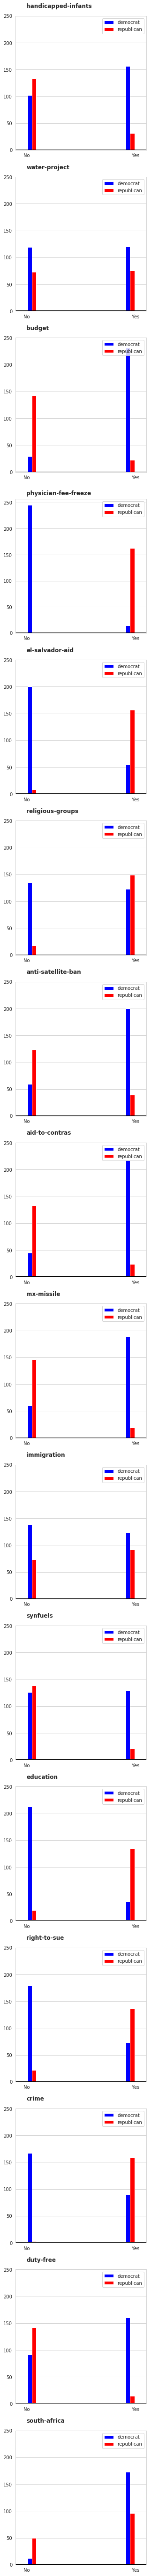

In [244]:
features = list(df)[1:]

fig, ax = plt.subplots(nrows=len(features), figsize=(5,100))
fig.patch.set_facecolor('white')

parties = [x for x, _ in df.groupby('party')]
colors = ['b', 'r']

for i, feature in zip(range(0,len(features)), features):
  ax[i].hist([df.loc[df['party']==party, feature].dropna() for party in parties], label = parties, align='mid', color=colors)

  ax[i].text(x=0, y=265, s=feature, fontweight='bold', fontsize=12);

  ax[i].set_xticks((0,1))
  ax[i].set_xlim([-0.1,1.1])
  ax[i].set_xticklabels(['No','Yes'])
  ax[i].set_yticks(range(0, 300, 50))
  ax[i].set_yticklabels(range(0, 300, 50))

  ax[i].axhline(linewidth=2, color="black")

  ax[i].legend(loc="upper right")

  ax[i].grid(axis='x')

plt.show()
